# De-Americanization Algorithm
------------------
> **Idriss Afra**

This project aims to construct the dividends and forwards curves for American stocks and indices.

## US Stock & Index Options Market
Market listed options on US stocks and indices are usually Americans. In fact, they can be exercised at any business day before maturity.
<br> Since the call-put parity is not valid for American options, practitioners cannot use this latter to imply forwards and dividends curves. For this reason, many de-Americanization algorithms have been developed to solve this limitation, and the simplest and the widly used one is the following :

Init :
- $n_{max}$, the maximum number of iterations
-   $F_0 = F(d_0)$, $d_0$ an initial dividend value guess and $F_0$ the initial forward value guess
- $K$, the strike of market call and put American options with the highest trading volume

While $n < n_{max}$ :
- Compute the implied American volatilities : $σ_{c}^{Amr}(K, F(d_k))$, $σ_{p}^{Amr}(K, F(d_k))$
- Compute the equivalent European prices : $C_{Eur}(K, σ_{c}^{Amr}(K, F(d_k)))$, $P_{Eur}(K, σ_{p}^{Amr}(K, F(d_k)))$
- Compute the forward using the call-put parity :

$$F_{k+1} = e^{rT} \left(C_{Eur}(K, σ_{c}^{Amr}(K, F(d_k))) - P_{Eur}(K, σ_{p}^{Amr}(K, F(d_k)))\right) + K $$

- Imply the associated dividend yield : $d_{k+1} = ln\left(\frac{Spot × e^{rT}}{F_{k+1}}\right) \div T$
- If :  $|F(d_k+1) - F(d_{k})| > ϵ$, Continue. Else : Break.

In this project, we use the Binomial model to imply American volatilities and price equivalent European options.

## The Binomial Model

Let's define the factors $u$ and $d$ as following :
$$
u = e^{\sigma\sqrt{\Delta t}}\qquad d = e^{-\sigma\sqrt{\Delta t}} \\
$$
Where $\sigma$ is the volatility. The risk-neutral probability under this model is :    
$$
p = \frac{e^{(r-q)\Delta t}-d}{u-d} \\
$$
So that :
$$
E(S_{t+\Delta t}) = p × u × S_t + (1 - p) × d × S_t  
= p × S_{t+\Delta t}^u + (1 - p) × S_{t+\Delta t}^d \\
$$

Where $r$ is the zero-coupon interest rate and $q$ the dividend yield.

The options are then priced using a backward mehod :

* European Style :  
$$
V_t(S_t) = e^{-r\Delta t}\left(p\times V_{t+\Delta t}(S_{t+\Delta t}^u)+(1-p)\times V_{t+\Delta t}(S_{t+\Delta t}^d)\right)
$$

* American Style :    
$$
V_t(S_t) = max\left(S_t - K, e^{-r\Delta t}\left(p\times V_{t+\Delta t}(S_{t+\Delta t}^u)+(1-p)\times V_{t+\Delta t}(S_{t+\Delta t}^d)\right)\right) \\
$$

With the $PayOff_T$ as final condition : $ V_T(S) = PayOff_T =Max\left((1_{Is Call} - 1_{Is Put}) × (S - K), 0 \right) $

In [1]:
import numpy as np
import math

def spot_simulation(S0, r, sigma, T, n_steps):
    """
    The spot simulation under the Binomial model.
    The function returns the Binomial tree.
    """
    dt = T / n_steps
    u = math.exp(sigma * math.sqrt(dt))
    d = 1. / u

    s = np.zeros((n_steps+1, n_steps+1))
    s[0,0] = S0
    for i in range(1, n_steps+1) :
        s[:i,i] = s[:i,i-1] * u
        s[i,i] = s[i-1,i-1] * d

    return s

# Test
spot_simulation(100, 0.03, 0.2, 1, 3)

array([[100.        , 112.24009024, 125.97837858, 141.39824581],
       [  0.        ,  89.09472523, 100.        , 112.24009024],
       [  0.        ,   0.        ,  79.37870064,  89.09472523],
       [  0.        ,   0.        ,   0.        ,  70.72223522]])

In [2]:
def tree_price(flavor, K, T, S0, r, sigma, q, amer=True, n_steps=750):
    """
    The Binomial model.
    The function returns the Binomial price.
    """
    # Spot simulation
    dt = T / n_steps
    u = math.exp(sigma * math.sqrt(dt))
    d = 1. / u
    p = (math.exp((r - q) * dt) - d) / (u - d)
    s = np.zeros((n_steps+1, n_steps+1))
    s[0,0] = S0
    for i in range(1, n_steps+1) :
        s[:i,i] = s[:i,i-1] * u
        s[i,i] = s[i-1,i-1] * d

    # Option payoff
    phi = 1 if flavor.upper() == "CALL" else -1
    v = np.maximum(phi * (s[:, n_steps] - K), 0.) # payoff at final date T

    # Discount between 2 time steps
    discount = math.exp(-r * dt)

    # Backward loop
    for i in range(n_steps-1, -1, -1) : # => i = n_steps-1 ... 0
        n_nodes = i+1 # i+1 nodes at time step #i
        v = discount * ( p * v[:n_nodes] + (1-p) * v[1:n_nodes+1] )
        if amer :
            v = np.maximum(phi * (s[:n_nodes, i] - K), v)

    return v[0]

# Test
print("Example of a Put option on stock with dividends :")
print("-------------------------------------------------")
print("American Put price", round(tree_price("Put", 100, 1, 105, 0.03, 0.2, 0.01), 4))
print("European Put price", round(tree_price("Put", 100, 1, 105, 0.03, 0.2, 0.01, False), 4))

Example of a Put option on stock with dividends :
-------------------------------------------------
American Put price 5.1462
European Put price 5.0191


## Implied American Volatilities

The first step of the above de-Americanization algorithm is the calibration of American volatilities using market listed call and put options with the highest trading volume. In this part, we use the Bisection method.

In [3]:
import sys

def amer_implied_vol(S0, r, T, K, flavor, q, market_price) :
    """
    Bisection algorithm on the Binomial model.
    The function returns the implied American vol.
    """
    sigma_min = 0.001
    sigma_max = 10
    n_max = 750
    eps = 1e-5

    n = 1
    while n <= n_max :
        sigma = (sigma_min + sigma_max)  / 2
        f_sigma = tree_price(flavor, K, T, S0, r, sigma, q) - market_price
        if (f_sigma == 0) or (sigma_max - sigma_min < eps) :
            return sigma
        if f_sigma < 0 :
            sigma_min = sigma
        else :
            sigma_max = sigma
        n += 1

    return sys.exit("The American volatility calibration algorithm failed to converge. Please review data of the " + flavor.upper() + " with Strike " + str(K))

# Test
print(str(100 * round(amer_implied_vol(100, 0.03, 1, 105, "Call", 0.01, 6.64), 4)) + "%")

20.0%


## De-Americanization Algorithm

In [4]:
def de_Americanization(T, S0, r, q_init, K, flavors, amer_prices) :
    """
    The de-Americanization algorithm function :
    1- Call the amer_implied_vol function to calibrate volatilities of the American call and put options with the highest trading volume (American Binomial model)
    2- Use these volatilities to re-price the equivalent European call and put prices (European Binomial model)
    3- Imply the forward using the call-put parity
    4- Re-do the 1st, 2nd, and 3rd steps until the convergence of the implied forward
    """
    n_max = 750
    eps = 1e-3

    if flavors[0].upper() == "CALL" :
        sigma_call = amer_implied_vol(S0, r, T, K, flavors[0], q_init, amer_prices[0])
        sigma_put = amer_implied_vol(S0, r, T, K, flavors[1], q_init, amer_prices[1])
    else :
        sigma_call = amer_implied_vol(S0, r, T, K, flavors[1], q_init, amer_prices[1])
        sigma_put = amer_implied_vol(S0, r, T, K, flavors[0], q_init, amer_prices[0])

    eur_price_call = tree_price("Call", K, T, S0, r, sigma_call, q_init, False)
    eur_price_put = tree_price("Put", K, T, S0, r, sigma_put, q_init, False)

    F = math.exp(r * T) * (eur_price_call - eur_price_put) + K
    q = math.log(S0 / F) / T + r
    nb_iteration = 1

    print("-----------------------------------------------------")
    print("Step : ", nb_iteration)
    print("Implied Forward : ", round(F, 4))
    print("Implied Dividend Yield : " + str(round(100 * q, 4)) + "%")

    while nb_iteration < n_max :
        if flavors[0].upper() == "CALL" :
            sigma_call = amer_implied_vol(S0, r, T, K, flavors[0], q, amer_prices[0])
            sigma_put = amer_implied_vol(S0, r, T, K, flavors[1], q, amer_prices[1])
        else :
            sigma_call = amer_implied_vol(S0, r, T, K, flavors[1], q, amer_prices[1])
            sigma_put = amer_implied_vol(S0, r, T, K, flavors[0], q, amer_prices[0])

        print("Market American Call Price : ", round(amer_prices[0], 4))
        print("Binomial American Call Price : ", round(tree_price(flavors[0], K, T, S0, r, sigma_call, q), 4))
        print("Implied American Call Vol : " + str(round(100 * sigma_call, 4)) + "%")
        print("Market American Put Price : ", round(amer_prices[1], 4))
        print("Binomial American Put Price : ", round(tree_price(flavors[1], K, T, S0, r, sigma_put, q), 4))
        print("Implied American Put Vol : " + str(round(100 * sigma_put, 4)) + "%")

        eur_price_call = tree_price("Call", K, T, S0, r, sigma_call, q, False)
        eur_price_put = tree_price("Put", K, T, S0, r, sigma_put, q, False)

        print("Equivalent Binomial European Call Price : ", round(eur_price_call, 4))
        print("Equivalent Binomial European Put Price : ", round(eur_price_put, 4))

        old_F = F
        F = math.exp(r * T) * (eur_price_call - eur_price_put) + K
        q = math.log(S0 / F) / T + r

        if abs(F - old_F) < eps :
            return F

        nb_iteration += 1
        
        print("-----------------------------------------------------")
        print("Step : ", nb_iteration)
        print("Implied Forward : ", round(F, 4))
        print("Implied Dividend Yield: " + str(round(100 * q, 4)) + "%")

    return sys.exit("The Dividends calibration algorithm failed to converge. Please review the inputs")


## Application : AAPL US Equity

Let us apply the above de-Americanization algorithm on the Apple US stock options : AAPL US. \\
Since several options with different strikes are generally quoted on each market tenor, we will naturally choose the strike with the highest trading volume on each tenor and use these latter in the de-Americanization algorithm.

In [5]:
from datetime import date
import matplotlib.pyplot as plt

now_date = date(2023, 8, 10)
S0 = 177.83
r = 5.482 / 100

tenor = date(2023, 12, 15)
T = (tenor - now_date).days / 365
# OTM listed American calls and puts prices
strikes = [165, 170, 175, 180, 185, 190]
amer_prices = [4.425, 5.75, 7.425, 10.125, 7.625, 5.5250]
flavors = ["Put"] * 3 + ["Call"] * 3

# The highest trading volume strike asof 8 Aug 2023 is 185. Its associated call option close price is 7.625 and its put option close price is 11.975
q_init = 0.0001
print("Dividend Yield Initial Guess : " + str(round(100 * q_init, 4)) + "%")
fwd = de_Americanization(T, S0, r, q_init, 185, ["Call", "Put"], [7.625, 11.975])
div_yield = math.log(S0 / fwd) / T + r
div_cash = S0 * math.exp(r * T) - fwd

print("-----------------------------------------------------")
print("Implied Fwd : ", round(fwd, 4))
print("Implied Dividend Yield : " + str(round(100 * div_yield, 4)) + "%")
print("Implied Cash Dividend : ", round(div_cash, 4))

Dividend Yield Initial Guess : 0.01%
-----------------------------------------------------
Step :  1
Implied Forward :  181.1041
Implied Dividend Yield : 0.2387%
Market American Call Price :  7.625
Binomial American Call Price :  7.625
Implied American Call Vol : 22.2912%
Market American Put Price :  11.975
Binomial American Put Price :  11.975
Implied American Put Vol : 22.3437%
Equivalent Binomial European Call Price :  7.625
Equivalent Binomial European Put Price :  11.469
-----------------------------------------------------
Step :  2
Implied Forward :  181.082
Implied Dividend Yield: 0.2737%
Market American Call Price :  7.625
Binomial American Call Price :  7.6248
Implied American Call Vol : 22.3151%
Market American Put Price :  11.975
Binomial American Put Price :  11.9751
Implied American Put Vol : 22.3236%
Equivalent Binomial European Call Price :  7.6248
Equivalent Binomial European Put Price :  11.4723
-----------------------------------------------------
Step :  3
Implied F

## Dividend Seasonality : Interpolation & Extrapolation

US companies tend to pay cash dividends during each quarter. They exhibit a strong seasonality in their dividends. 
Therefore, practitioners forcast future dividend payment dates by simply keeping the same historical payment days and months for the next years. A new "seasoned" dividends curve is then bootstrapped as the following : 

Under the Non-Arbitrage assumption : $F_T = S_t × e^{r (T-t)} - ∑_{k ∈ [1,n]}d_k × e^{r(T-T_k)}$ 

Therefore :  $d_n = e^{-r(T-T_n)} × \left( S_t × e^{r (T-t)} - ∑_{k ∈ [1,n-1]}d_k × e^{r(T-T_k)} - F_T \right)$ 

And finally : $d_n = S_t × e^{r (T_n-t)} - ∑_{k ∈ [1,n-1]}d_k × e^{r(T_n-T_k)} - F_T × e^{-r(T-T_n)}$ 


Where  :

* $S_t$ the spot price at $t$
* $r$ the zero-coupon rate
* $F_T$ the calibrated forward of the market option tenor $T$ by the de-Americanization algorithm
* $d_k$ the $k^{th}$ cash dividend to be paid at $T_k$

<br>On the other side, practitioners usually assume continious dividend yield curve for US Indices. The simplest way to construct such curve is to suppose a piecewise constant curve between market options tenors :

Under the Non-Arbitrage assumption : $F_T = S_t × e^{r (T-t) - ∑_{k ∈ [1,n]}q_k × (T_k-T_{k-1})}$ 

Therefore : $q_n = ln\left( S_t × e^{r (T-t) - ∑_{k ∈ [1,n-1]}q_k × (T_k-T_{k-1})} / F_T \right) / \left( T_n - T_{n-1}\right)$

Where  :

* $S_t$ the spot price at $t$
* $r$ the zero-coupon rate
* $F_T$ the calibrated forward of the market option tenor $T$ by the de-Americanization algorithm
* $q_k$ the $k^{th}$ continious yield dividend between $T_{k-1}$ and $T_{k}$

<br> Cash and yield dividends can then be flat extrapolated after the last market option tenor.

## Implied European Volatilities

Once the forwards and dividends curves calibrated, we need to compute implied European volatilies in order to price European derivatives on an US underlying stock. To do so, we assume the equivalent European Binomial prices to be market prices and use these latter to imply European volatilities under the Black-Scholes standard market model :

Init :
- $F = F(d)$, $d$ and $F$ are the calibrated dividend yield and forward price by the above de-Americanization algorithm
- $Strikes$, the quoted strikes of OTM American call and put options on a given market tenor $T$

For $K$ in $Strikes$ :
- Compute the implied American Binomial volatility : $σ_{Amr}(K, F(d))$
- Compute the equivalent European Binomial price : $Binomial_{EUR}(K, σ_{Amr}(K, F(d)))$
- Calibrate the Implied European Volatilities $\sigma_{Imp}(K,T)$ such that :

$$
BS(F(d), K, \sigma_{Imp}(K,T), T) - Binomial_{EUR}(K, σ_{Amer}(K, F(d))) = 0  $$

The $\sigma_{Imp}(K,T)$ calibration is done via the Newton-Raphson method.



In [6]:
from scipy.stats import norm

def black_scholes(flavor, K, T, S, r, vol, q=0) :
    """
    The Black-Scholes price.
    """
    v2T = vol**2 * T
    d1 = (np.log(S/K) + (r - q) * T + v2T / 2) / v2T**0.5
    d2 = d1 - v2T**0.5
    phi = 1 if flavor.upper() == "CALL" else  -1
    return phi * (S * math.exp(-q * T) * norm.cdf(phi * d1) - K * math.exp(-r * T) * norm.cdf(phi * d2))

def vega_bs(K, T, S, r, vol, q=0) :
    """
    The Black-Scholes Vega greek : The derivative of the option value with respect to the volatility of the underlying asset.
    """
    v2T = vol**2 * T
    d2 = (math.log(S/K) + (r - q) * T - v2T / 2) / v2T**0.5
    return K * math.exp(-r * T) * norm.pdf(d2) * T**0.5

def newton_raphson(market_price, init_vol, flavor, K, T, S, r, q=0):
    """
    The Newton-Raphson algorithm : Implied volatilities from market prices
    """
    eps = 1e-07
    vol = init_vol
    func = black_scholes(flavor, K, T, S, r, vol, q) - market_price
    func_deriv = vega_bs(K, T, S, r, vol, q)
    error = sys.exit("The European volatility calibration algorithm failed to converge. Please review the " + flavor.upper() + " of Strike " + str(K)) if func_deriv < 0.0001 else "No error."
    next_vol = vol - func / func_deriv
    error = sys.exit("The European volatility calibration algorithm failed to converge. Please review the " + flavor.upper() + " of Strike " + str(K)) if next_vol < 0.0001 else "No error."

    nb_iteration = 1
    while abs(next_vol - vol) > eps :
        vol = next_vol
        func = black_scholes(flavor, K, T, S, r, vol, q) - market_price
        func_deriv = vega_bs(K, T, S, r, vol, q)
        error = sys.exit("The European volatility calibration algorithm failed to converge. Please review the " + flavor.upper() + " of Strike " + str(K)) if func_deriv < 0.0001 else "No error."
        next_vol = vol - func / func_deriv
        error = sys.exit("The European volatility calibration algorithm failed to converge. Please review the " + flavor.upper() + " of Strike " + str(K)) if next_vol < 0.0001 else "No error."
        nb_iteration += 1
        error = sys.exit("The European volatility calibration algorithm failed to converge. Please review the " + flavor.upper() + " of Strike " + str(K)) if nb_iteration > 300 else "No error."

    return next_vol

In [7]:
def euro_equivalent_vol(T, S0, r, q, K, flavor, amer_price) :
    """
    This function calibrates the implied European volatility of a given strike K and tenor T
    """
    amr_vol = amer_implied_vol(S0, r, T, K, flavor, q, amer_price)
    eur_price = tree_price(flavor, K, T, S0, r, amr_vol, q, False)
    return newton_raphson(eur_price, amr_vol, flavor, K, T, S0, r, q)

Let us get back our example of AAPL US stock options and calibrate its equivalent implied European volatilities :

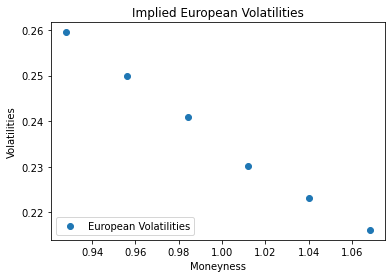

In [8]:
eur_vol = []

for i in range(len(strikes)) :
    eur_vol.append(euro_equivalent_vol(T, S0, r, div_yield, strikes[i], flavors[i], amer_prices[i]))

plt.ylabel("Volatilities")
plt.xlabel("Moneyness")
plt.title("Implied European Volatilities")
plt.scatter(np.array(strikes) / S0, eur_vol, label="European Volatilities")
plt.legend(loc="lower left")
plt.show()